# Sample use of the sun topic model 

In [1]:
import numpy as np
from suntm import SunTopic
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Generate random data as the 'embeddings' for the 'documents' in the corpus
np.random.seed(2024)
n = 2000
m = 100
J = 10
W_t = np.random.rand(n, J)
H_t = np.random.rand(J, m)
X = np.dot(W_t, H_t) + np.random.rand(n, m) * 0.05
coef_true = np.random.normal(0, 1, J)
Y = np.dot(W_t, coef_true) + np.random.rand(n) * 0.05
Y = (Y - np.mean(Y)) / np.std(Y)

In [3]:
# Split the data into a training and an estimation set
X_train = X[:1500, :]
X_est = X[1500:, :]
Y_train = Y[:1500]
Y_est = Y[1500:]

# Initialize and fit the model for random hyperparameter choices
model = SunTopic(Y=Y_train, X=X_train, alpha=0.5, num_bases=3, random_state=2024)
model.fit()
model.summary()


            SunTopic Model Summary
            Number of topics: 3
            Alpha: 0.5
            Data shape: (1500, 101)
            Number of iterations of model fit: 100
            Random initialization state: 2024
            Frobenius norm error: 71.06660610331244
            In-sample MSE: 0.6725848829359896
            Prediction coefficients: [-0.24148938  0.2146859   0.017745  ]
            


In [4]:
# Use cross validation for finding optimal hyperparameters: number of bases and alpha
model.hyperparam_cv(
    alpha_range=np.linspace(0.1, 0.9, 9),
    num_bases_range=np.arange(2, 11),
    cv_folds=5,
    random_state=2024,
)
model.cv_summary()

Cross-Validation Progress: 100%|██████████| 405/405 [12:02<00:00,  1.78s/it]


            Cross-Validation Summary
            Alpha candidate values: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
            Number of topics: [ 2  3  4  5  6  7  8  9 10]
            Number of folds: 5
            CV Random state: 2024
            
Top 1 hyperparam combinations - num_bases: 3.00,alpha: 0.10, MSE: 0.3989
Top 2 hyperparam combinations - num_bases: 2.00,alpha: 0.10, MSE: 0.4389
Top 3 hyperparam combinations - num_bases: 4.00,alpha: 0.20, MSE: 0.4925


In [5]:
# Use parallelization to speed up the hyperparameter search
model.hyperparam_cv(
    alpha_range=np.linspace(0.1, 0.9, 9),
    num_bases_range=np.arange(2, 11),
    cv_folds=5,
    random_state=2024,
    parallel=True,
)
model.cv_summary()

Cross-Validation Progress:  53%|█████▎    | 216/405 [03:25<03:58,  1.26s/it]/Users/tillrs/micromamba/envs/sun_topicmodel/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Cross-Validation Progress: 100%|██████████| 405/405 [09:09<00:00,  1.36s/it]


            Cross-Validation Summary
            Alpha candidate values: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
            Number of topics: [ 2  3  4  5  6  7  8  9 10]
            Number of folds: 5
            CV Random state: 2024
            
Top 1 hyperparam combinations - num_bases: 3.00,alpha: 0.10, MSE: 0.3989
Top 2 hyperparam combinations - num_bases: 2.00,alpha: 0.10, MSE: 0.4389
Top 3 hyperparam combinations - num_bases: 4.00,alpha: 0.20, MSE: 0.4925


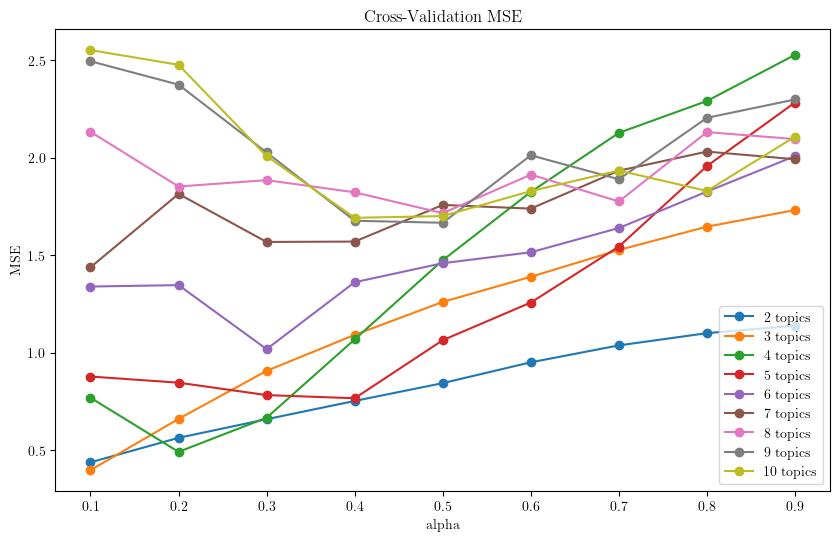

In [6]:
# Use in-built plotting functions to visualize the results
model.cv_mse_plot()

# Estimate Average Marginal Component Effect (AMCE) of Topics

In [7]:
# Initialize and fit the model with best hyperparameters
model = SunTopic(Y=Y_train, X=X_train, alpha=0.7, num_bases=8, random_state=2024)
model.fit()
model.summary()


            SunTopic Model Summary
            Number of topics: 8
            Alpha: 0.7
            Data shape: (1500, 101)
            Number of iterations of model fit: 100
            Random initialization state: 2024
            Frobenius norm error: 72.9934490647815
            In-sample MSE: 0.3797984803382969
            Prediction coefficients: [-0.09342196  0.05290105 -0.03908141 -0.17794037  0.27778751 -0.1728278
  0.05832648 -0.20810589]
            


In [8]:
# Save and load the model
model.save("model")
model_loaded = SunTopic.load("model.npz")

In [10]:
Y_est_pred, W_est = model_loaded.predict(X_est, return_topics=True)
print(f"{W_est.shape = }")

# Fit a linear regression model to the estimated topics
W_est = sm.add_constant(W_est)
model_est = sm.OLS(Y_est, W_est).fit()
model_est.summary()

W_est.shape = (500, 8)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     242.6
Date:                Fri, 20 Feb 2026   Prob (F-statistic):          3.35e-165
Time:                        17:15:45   Log-Likelihood:                -336.82
No. Observations:                 500   AIC:                             691.6
Df Residuals:                     491   BIC:                             729.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7321      0.117     23.419      0.000       2.503       2.961
x1            -0.4731      0.023    -20.239      0.000      -0.519      -0.427
x2            -0.2750      0.011    -24.652      0.000      -0.297      -0.253
x3            -0.4529      0.016    -28.787      0.000      -0.484      -0.422
x4            -0.6833      0.026    -25.911      0.000      -0.735      -0.631
x5             0.4258      0.020     21.026      0.000       0.386       0.466
x6            -0.7075      0.019    -37.391      0.000      -0.745      -0.670
x7            -0.2318      0.019    -12.027      0.000      -0.270      -0.194
x8            -0.8916      0.029    -30.934      0.000      -0.948      -0.835
==============================================================================
Omnibus:                        6.085   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                4.232
Skew:                           0.067   Prob(JB):                        0.121
Kurtosis:                       2.570   Cond. No.                         30.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<>:56: SyntaxWarning: invalid escape sequence '\%'
<>:56: SyntaxWarning: invalid escape sequence '\%'
/var/folders/1n/l1qs9bwj2h9c06x52w17rfdm0000gp/T/ipykernel_68359/1472761143.py:56: SyntaxWarning: invalid escape sequence '\%'
  ax.set_title("Estimates of Topic Effects with 95\% Confidence Intervals", fontsize=14)


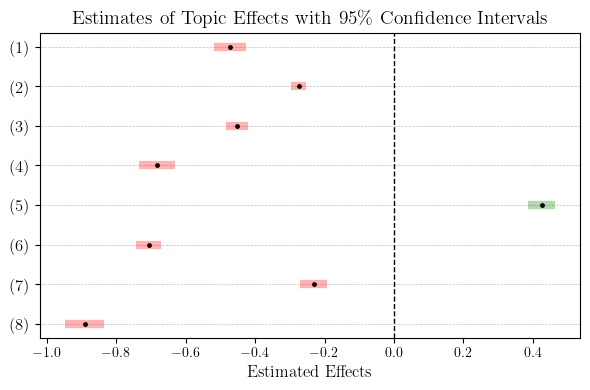

In [12]:
# Set font to Computer Modern
plt.rcParams["text.usetex"] = True

# Extract parameters and confidence intervals from the regression results
params = model_est.params[1:]
conf_int = model_est.conf_int()[1:]

# Plot the parameters
fig, ax = plt.subplots(figsize=(6, 4))

for i, (param, (lower, upper)) in enumerate(zip(params, conf_int)):
    # Add horizontal lines between rows
    ax.axhline(i, color="gray", linestyle="--", linewidth=0.5, alpha=0.5)

    if lower <= 0 & 0 <= upper:
        ax.plot(
            [lower, upper],
            [i, i],
            color="lightgray",
            linewidth=6,
            solid_capstyle="butt",
            alpha=0.7,
        )
        ax.scatter(param, i, marker="o", s=6, color="black", zorder=10)

    elif lower <= 0 & 0 >= upper:
        ax.plot(
            [lower, upper],
            [i, i],
            color="red",
            linewidth=6,
            solid_capstyle="butt",
            alpha=0.3,
        )
        ax.scatter(param, i, marker="o", s=6, color="black", zorder=10)

    else:
        ax.plot(
            [lower, upper],
            [i, i],
            color="green",
            linewidth=6,
            solid_capstyle="butt",
            alpha=0.3,
        )
        ax.scatter(param, i, marker="o", s=6, color="black", zorder=10)

# Customize the plot
ax.axvline(0, color="black", linestyle="--", linewidth=1)  # Add a vertical line at x=0
ax.yaxis.tick_left()
ax.invert_yaxis()  # Flip the graph
ax.set_yticks(np.arange(len(params)))
ax.set_yticklabels([f"({i+1})" for i in range(len(model_est.params) - 1)], fontsize=12)
ax.set_xlabel("Estimated Effects", fontsize=12)
# include lin break in the title
ax.set_title("Estimates of Topic Effects with 95\% Confidence Intervals", fontsize=14)


# Save or show the plot
plt.tight_layout()

plt.show()